In [1]:
# Load your dataset
import pandas as pd
file_path = "/kaggle/input/mobile-banking-fraud-data-synthetic/multi_user_data.feather"  # Update with your file path
data = pd.read_feather(file_path)

In [2]:
from sklearn.preprocessing import LabelEncoder

# Convert object columns to categorical and datetime columns
for col in data.select_dtypes(include='object').columns:
    if col in ['LastLoginTime', 'TimeOfTransaction']:
        data[col] = pd.to_datetime(data[col])

# Encode categorical variables
categorical_columns = ['SwipeDirection', 'NavigationFlow', 'TransactionType', 'TransactionMethod', 'SuccessFailureStatus']
label_encoders = {}
for col in categorical_columns:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])
    label_encoders[col] = encoder


### Train AutoEncoder for Anomaly Detection

Training Behavioral Autoencoder...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - loss: 12.5346 - val_loss: 1.8931 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4543 - val_loss: 1.8188 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9277 - val_loss: 1.7796 - learning_rate: 0.0010
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7856 - val_loss: 1.7382 - learning_rate: 0.0010
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7576 - val_loss: 1.6972 - learning_rate: 0.0010
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6799 - val_loss: 1.6561 - learning_rate: 0.0010
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6359 - val_loss: 1.6163 - learning_rate: 0.0010
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5861 - val_loss: 1.5773 - learning_rate: 0.0010
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5488 - val_loss: 1.5411 - learning_rate: 0.0010
Epoch 10/100
31/3

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


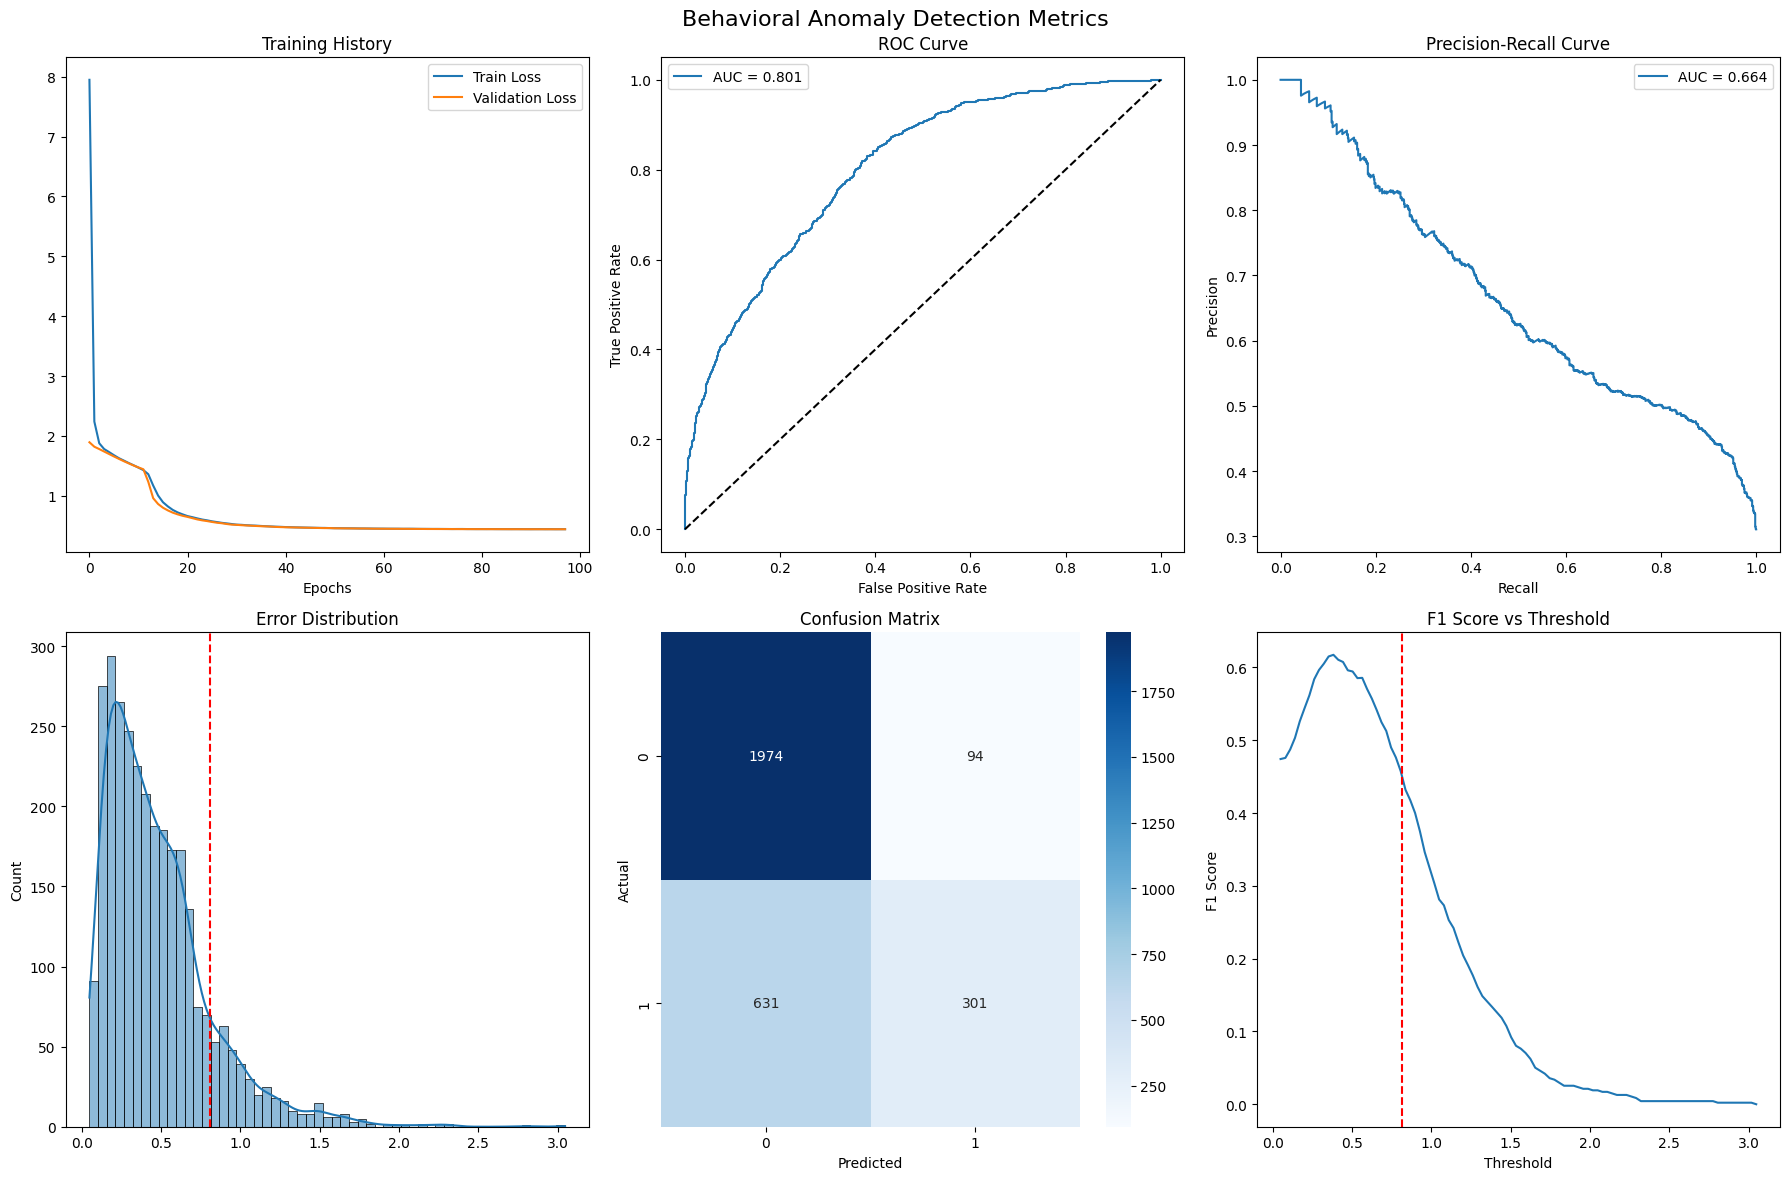

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


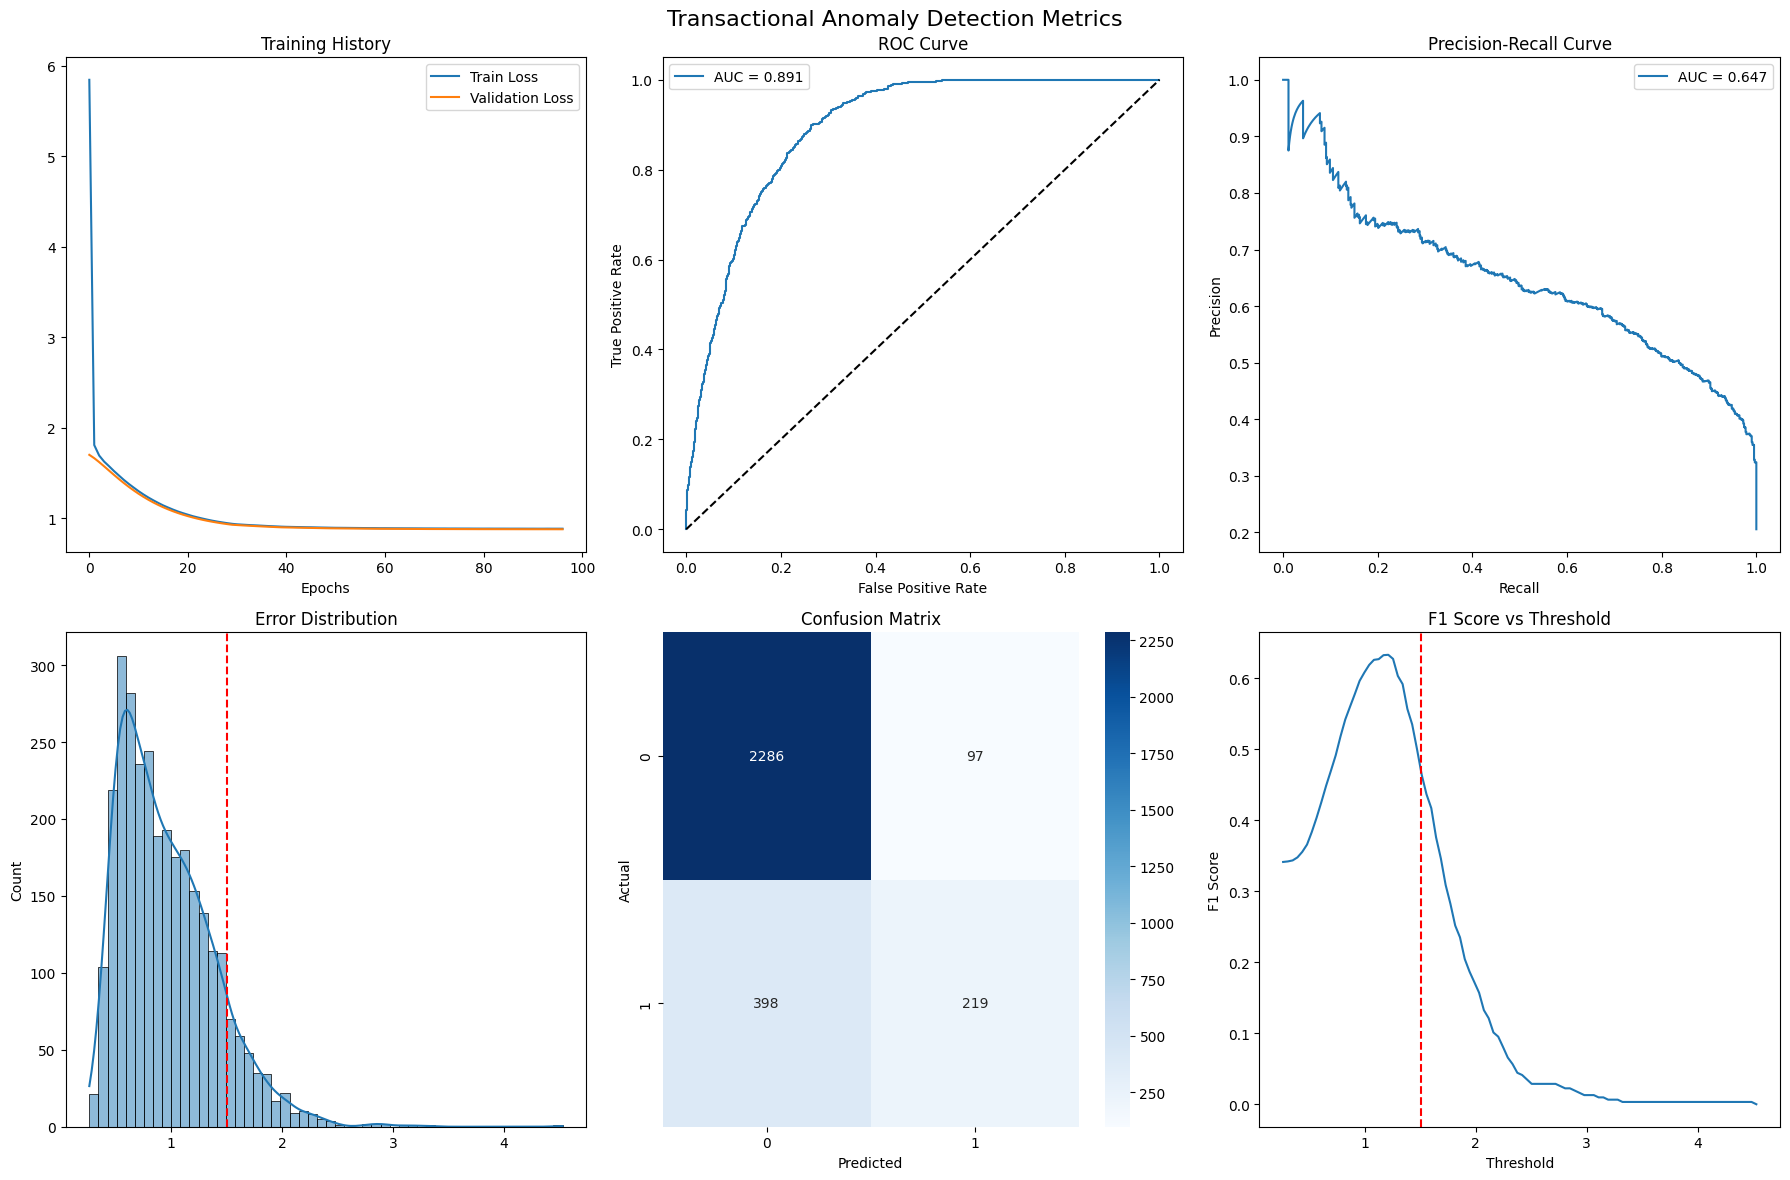

['tran_scaler.joblib']

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# --------------------------
# 1. Data Preparation
# --------------------------
# Load your dataset
import pandas as pd
file_path = "/kaggle/input/mobile-banking-fraud-data-synthetic/multi_user_data.feather"  # Update with your file path
data = pd.read_feather(file_path)

from sklearn.preprocessing import LabelEncoder

# Convert object columns to categorical and datetime columns
for col in data.select_dtypes(include='object').columns:
    if col in ['LastLoginTime', 'TimeOfTransaction']:
        data[col] = pd.to_datetime(data[col])

# Encode categorical variables
categorical_columns = ['SwipeDirection', 'NavigationFlow', 'TransactionType', 'TransactionMethod', 'SuccessFailureStatus']
label_encoders = {}
for col in categorical_columns:
    encoder = LabelEncoder()
    data[col] = encoder.fit_transform(data[col])
    label_encoders[col] = encoder

# Feature lists with corrections
behavioral_features = [
    'TypingSpeed', 'TypingPressure', 'SwipeSpeed', 'TapDuration', 'ScrollingSpeed',
    'SessionDuration', 'SwipeDirection', 'TouchHeatmap', 'GestureFrequency', 'NavigationFlow'
]
transactional_features = [
    'TransactionAmount', 'TransactionType', 'TransactionMethod', 'TransactionLatitude', 
    'TransactionLongitude', 'SuccessFailureStatus', 'AuthenticationAttempts', 'MFATrigger', 
    'HolidayIndicator', 'EventBasedIndicator', 'TimeConsistency', 'TransactionFrequency', 
    'LocationConsistency', 'GeolocationVelocity'
]

# --------------------------
# 2. Data Splitting
# --------------------------
# Stratified split based on anomaly flags
train_data, test_data = train_test_split(
    data, 
    test_size=0.3, 
    stratify=data[['behav_AnomalyFlag', 'tran_AnomalyFlag']],
    random_state=42
)

# --------------------------
# 3. Data Preprocessing
# --------------------------
def prepare_data(dataset, features, anomaly_flag, scaler=None):
    """Prepare data with proper scaling and normal samples filtering"""
    normal_data = dataset[dataset[anomaly_flag] == 0][features]
    if scaler is None:
        scaler = StandardScaler().fit(normal_data)
    scaled_data = scaler.transform(normal_data)
    return scaler, scaled_data

# Behavioral data preparation
behav_scaler, behav_train = prepare_data(train_data, behavioral_features, 'behav_AnomalyFlag')
behav_test = behav_scaler.transform(test_data[behavioral_features])

# Transactional data preparation
tran_scaler, tran_train = prepare_data(train_data, transactional_features, 'tran_AnomalyFlag')
tran_test = tran_scaler.transform(test_data[transactional_features])

# --------------------------
# 4. Model Architecture
# --------------------------
def create_autoencoder(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim, kernel_initializer='he_normal'),
        Dropout(0.3),
        Dense(64, activation='relu', kernel_regularizer='l2'),
        Dropout(0.2),
        Dense(32, activation='relu', activity_regularizer='l1'),
        Dense(64, activation='relu'),
        Dense(128, activation='relu'),
        Dense(input_dim, activation='linear')
    ])
    return model

# Learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch > 20 and epoch % 10 == 0:
        return lr * 0.5
    return lr

# --------------------------
# 5. Training Function
# --------------------------
def train_autoencoder(data, input_dim):
    autoencoder = create_autoencoder(input_dim)
    
    optimizer = Adam(learning_rate=0.001)
    # Use explicit loss function instead of string
    autoencoder.compile(optimizer=optimizer, loss=MeanSquaredError())
    
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        min_delta=0.001
    )
    
    history = autoencoder.fit(
        data, data,
        epochs=100,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stopping, LearningRateScheduler(lr_scheduler)],
        verbose=1,
        shuffle=True
    )
    return autoencoder, history

# --------------------------
# 6. Model Training
# --------------------------
print("Training Behavioral Autoencoder...")
behavioral_autoencoder, behav_history = train_autoencoder(behav_train, behav_train.shape[1])

print("\nTraining Transactional Autoencoder...")
transactional_autoencoder, tran_history = train_autoencoder(tran_train, tran_train.shape[1])

# --------------------------
# 7. Threshold Determination
# --------------------------
def calculate_threshold(model, normal_data):
    reconstructions = model.predict(normal_data)
    errors = np.mean(np.square(reconstructions - normal_data), axis=1)
    return np.percentile(errors, 95)

behav_threshold = calculate_threshold(behavioral_autoencoder, behav_train)
tran_threshold = calculate_threshold(transactional_autoencoder, tran_train)

# --------------------------
# 8. Evaluation Functions
# --------------------------
def evaluate_model(model, test_data, true_labels, threshold, feature_type):
    # Calculate reconstruction errors
    reconstructions = model.predict(test_data)
    errors = np.mean(np.square(reconstructions - test_data), axis=1)
    
    # Generate predictions
    predictions = errors > threshold
    
    # Calculate metrics
    print(f"\n{feature_type} Anomaly Evaluation:")
    print(classification_report(true_labels, predictions))
    
    # Calculate AUC-ROC
    fpr, tpr, _ = roc_curve(true_labels, errors)
    roc_auc = roc_auc_score(true_labels, errors)
    
    # Calculate AUC-PR
    precision, recall, _ = precision_recall_curve(true_labels, errors)
    pr_auc = auc(recall, precision)
    
    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    
    return {
        'errors': errors,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'cm': cm,
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall
    }

# --------------------------
# 9. Model Evaluation
# --------------------------
# Behavioral evaluation
behav_results = evaluate_model(
    behavioral_autoencoder,
    behav_test,
    test_data['behav_AnomalyFlag'],
    behav_threshold,
    "Behavioral"
)

# Transactional evaluation
tran_results = evaluate_model(
    transactional_autoencoder,
    tran_test,
    test_data['tran_AnomalyFlag'],
    tran_threshold,
    "Transactional"
)

# --------------------------
# 10. Enhanced Visualization
# --------------------------
def plot_metrics(results, history, title):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16)

    # Training History
    axs[0,0].plot(history.history['loss'], label='Train Loss')
    axs[0,0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0,0].set_title('Training History')
    axs[0,0].set_xlabel('Epochs')
    axs[0,0].legend()

    # ROC Curve
    axs[0,1].plot(results['fpr'], results['tpr'], label=f"AUC = {results['roc_auc']:.3f}")
    axs[0,1].plot([0, 1], [0, 1], 'k--')
    axs[0,1].set_title('ROC Curve')
    axs[0,1].set_xlabel('False Positive Rate')
    axs[0,1].set_ylabel('True Positive Rate')
    axs[0,1].legend()

    # Precision-Recall Curve
    axs[0,2].plot(results['recall'], results['precision'], label=f"AUC = {results['pr_auc']:.3f}")
    axs[0,2].set_title('Precision-Recall Curve')
    axs[0,2].set_xlabel('Recall')
    axs[0,2].set_ylabel('Precision')
    axs[0,2].legend()

    # Error Distribution
    sns.histplot(results['errors'], kde=True, ax=axs[1,0])
    axs[1,0].axvline(x=behav_threshold if "Behavioral" in title else tran_threshold, color='r', linestyle='--')
    axs[1,0].set_title('Error Distribution')

    # Confusion Matrix
    sns.heatmap(results['cm'], annot=True, fmt='d', cmap='Blues', ax=axs[1,1])
    axs[1,1].set_title('Confusion Matrix')
    axs[1,1].set_xlabel('Predicted')
    axs[1,1].set_ylabel('Actual')

    # Threshold Analysis
    thresholds = np.linspace(min(results['errors']), max(results['errors']), 100)
    f1_scores = [f1_score(test_data['behav_AnomalyFlag'] if "Behavioral" in title else test_data['tran_AnomalyFlag'], 
                         results['errors'] > t) for t in thresholds]
    axs[1,2].plot(thresholds, f1_scores)
    axs[1,2].axvline(x=behav_threshold if "Behavioral" in title else tran_threshold, color='r', linestyle='--')
    axs[1,2].set_title('F1 Score vs Threshold')
    axs[1,2].set_xlabel('Threshold')
    axs[1,2].set_ylabel('F1 Score')

    plt.tight_layout()
    plt.show()

plot_metrics(behav_results, behav_history, "Behavioral Anomaly Detection Metrics")
plot_metrics(tran_results, tran_history, "Transactional Anomaly Detection Metrics")

# --------------------------
# 11. Model Saving (Corrected)
# --------------------------
# Save full models (architecture + weights)
behavioral_autoencoder.save('behavioral_autoencoder.keras')  # New recommended format
transactional_autoencoder.save('transactional_autoencoder.keras')

# Save just the weights (with correct suffix)
behavioral_autoencoder.save_weights('behavioral_autoencoder.weights.h5')  # Notice the .weights.h5 suffix
transactional_autoencoder.save_weights('transactional_autoencoder.weights.h5')

# At the end of Model 1's code (under section 11. Model Saving)
from joblib import dump

# Save scalers
dump(behav_scaler, 'behav_scaler.joblib')
dump(tran_scaler, 'tran_scaler.joblib')

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


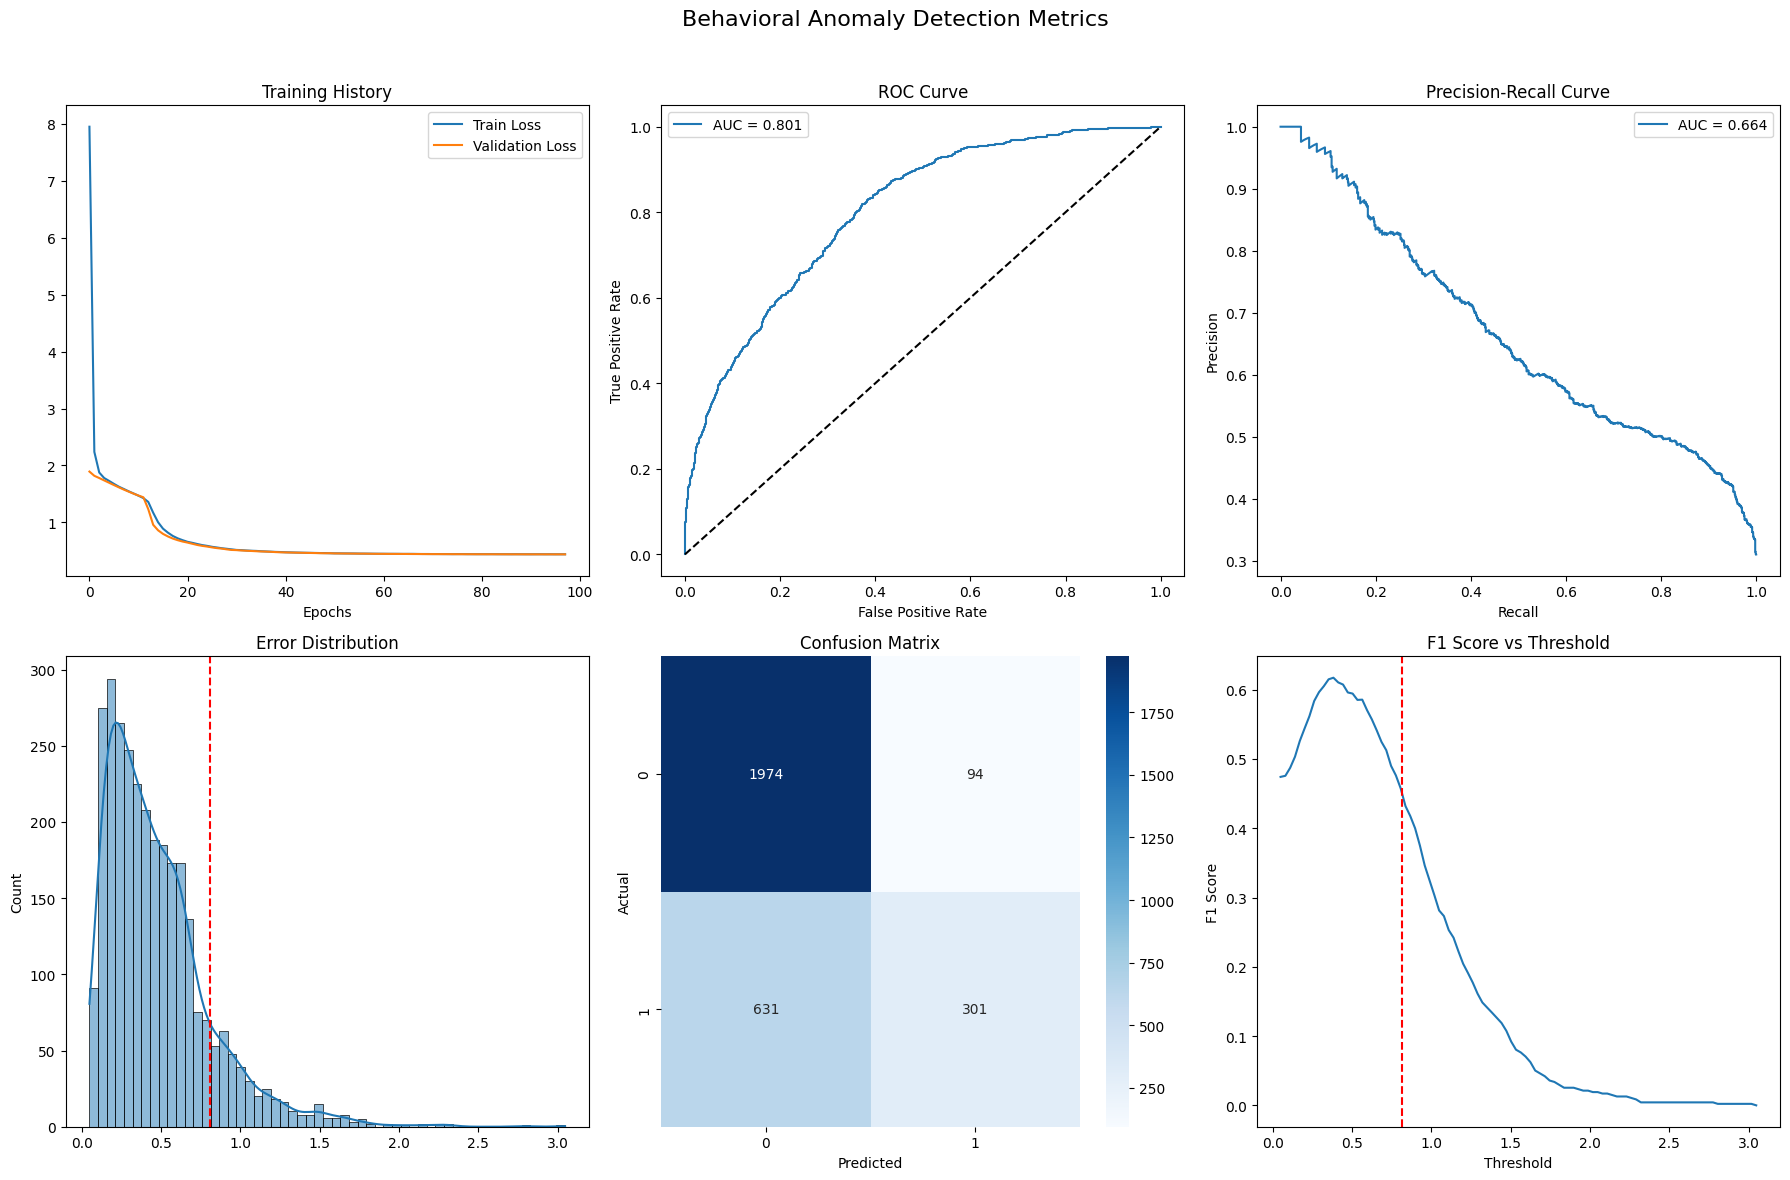

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


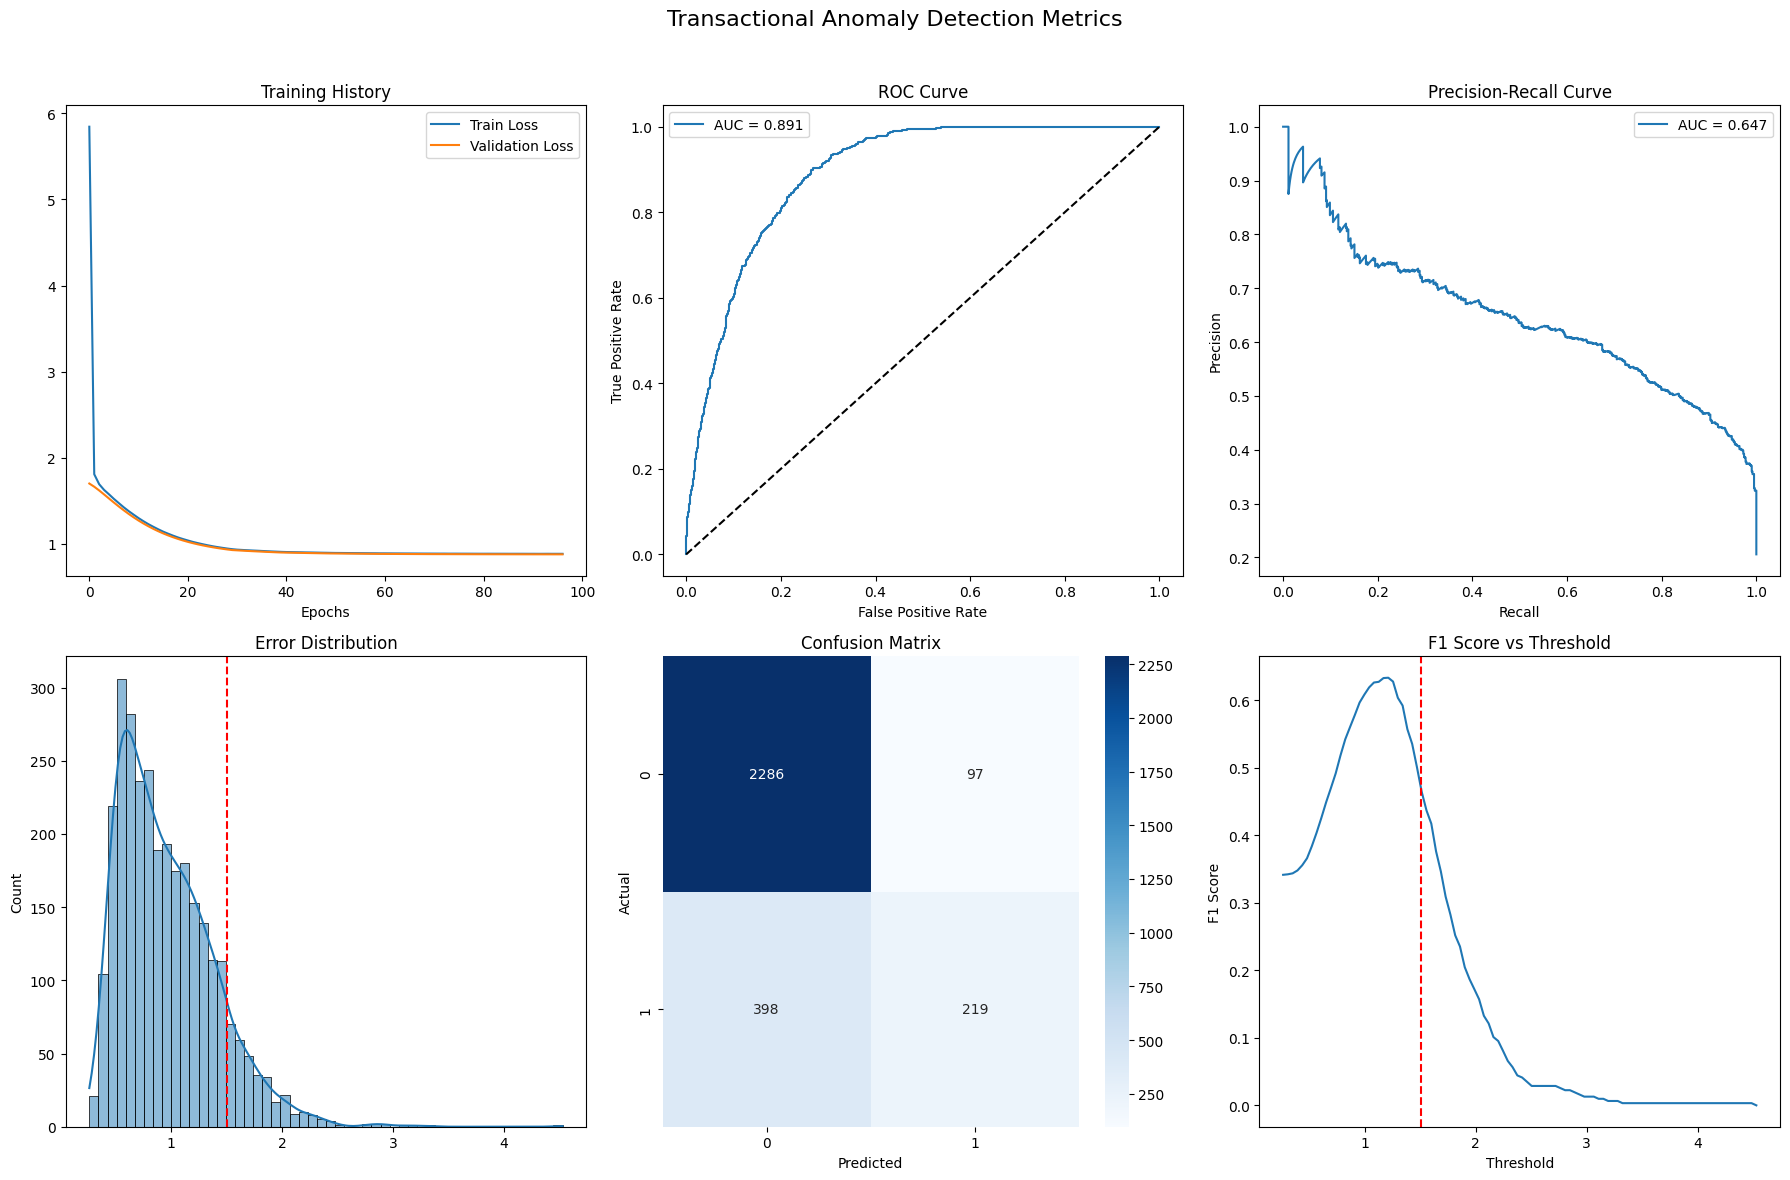

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

def plot_metrics(results, history, title, save_dir=None):
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)

    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(title, fontsize=16)

    # 1) Training History
    axs[0,0].plot(history.history['loss'], label='Train Loss')
    axs[0,0].plot(history.history['val_loss'], label='Validation Loss')
    axs[0,0].set_title('Training History')
    axs[0,0].set_xlabel('Epochs')
    axs[0,0].legend()

    # 2) ROC Curve
    axs[0,1].plot(results['fpr'], results['tpr'], label=f"AUC = {results['roc_auc']:.3f}")
    axs[0,1].plot([0, 1], [0, 1], 'k--')
    axs[0,1].set_title('ROC Curve')
    axs[0,1].set_xlabel('False Positive Rate')
    axs[0,1].set_ylabel('True Positive Rate')
    axs[0,1].legend()

    # 3) Precision-Recall Curve
    axs[0,2].plot(results['recall'], results['precision'], label=f"AUC = {results['pr_auc']:.3f}")
    axs[0,2].set_title('Precision-Recall Curve')
    axs[0,2].set_xlabel('Recall')
    axs[0,2].set_ylabel('Precision')
    axs[0,2].legend()

    # 4) Error Distribution
    sns.histplot(results['errors'], kde=True, ax=axs[1,0])
    threshold = behav_threshold if "Behavioral" in title else tran_threshold
    axs[1,0].axvline(x=threshold, color='r', linestyle='--')
    axs[1,0].set_title('Error Distribution')

    # 5) Confusion Matrix
    sns.heatmap(results['cm'], annot=True, fmt='d', cmap='Blues', ax=axs[1,1])
    axs[1,1].set_title('Confusion Matrix')
    axs[1,1].set_xlabel('Predicted')
    axs[1,1].set_ylabel('Actual')

    # 6) Threshold Analysis
    thr_vals = np.linspace(min(results['errors']), max(results['errors']), 100)
    flags = test_data['behav_AnomalyFlag'] if "Behavioral" in title else test_data['tran_AnomalyFlag']
    f1_scores = [f1_score(flags, results['errors'] > t) for t in thr_vals]
    axs[1,2].plot(thr_vals, f1_scores)
    axs[1,2].axvline(x=threshold, color='r', linestyle='--')
    axs[1,2].set_title('F1 Score vs Threshold')
    axs[1,2].set_xlabel('Threshold')
    axs[1,2].set_ylabel('F1 Score')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if save_dir:
        base_name = title.replace(" ", "_")
        # Save combined figure
        fig.savefig(os.path.join(save_dir, f"{base_name}.png"), dpi=300)
        fig.savefig(os.path.join(save_dir, f"{base_name}.svg"))

        # Now save individual panels properly
        fig.canvas.draw()
        renderer = fig.canvas.get_renderer()
        for idx, ax in enumerate(axs.flatten(), start=1):
            bbox_disp = ax.get_window_extent(renderer=renderer)
            bbox_inches = bbox_disp.transformed(fig.dpi_scale_trans.inverted())

            png_path = os.path.join(save_dir, f"{base_name}_subplot_{idx}.png")
            svg_path = os.path.join(save_dir, f"{base_name}_subplot_{idx}.svg")
            fig.savefig(png_path, bbox_inches=bbox_inches, dpi=300)
            fig.savefig(svg_path, bbox_inches=bbox_inches)

    plt.show()


# Example calls:
plot_metrics(behav_results, behav_history, "Behavioral Anomaly Detection Metrics", save_dir="plots")
plot_metrics(tran_results, tran_history,   "Transactional Anomaly Detection Metrics", save_dir="plots")


### Train LSTM for Sequence Data

<ipython-input-5-07528328a46b>:88: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[features] = data[features].fillna(method='ffill').fillna(0)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.6906 - loss: 0.5492 - precision: 0.5095 - recall: 0.7903 - val_accuracy: 0.8324 - val_loss: 0.4754 - val_precision: 0.7070 - val_recall: 0.8078 - learning_rate: 0.0010
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8565 - loss: 0.2736 - precision: 0.7345 - recall: 0.8157 - val_accuracy: 0.8139 - val_loss: 0.3328 - val_precision: 0.9034 - val_recall: 0.4644 - learning_rate: 0.0010
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8921 - loss: 0.2262 - precision: 0.8094 - recall: 0.8517 - val_accuracy: 0.8558 - val_loss: 0.2688 - val_precision: 0.9502 - val_recall: 0.5767 - learning_rate: 0.0010
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9170 - loss: 0.1912 - precision: 0.8506 - recall: 0.8916 - val_accuracy: 0.8510 - val_loss: 0.2607 - val_precision: 0.9624 - val_recall: 0.5529 - learning_rate: 0.0010
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.91

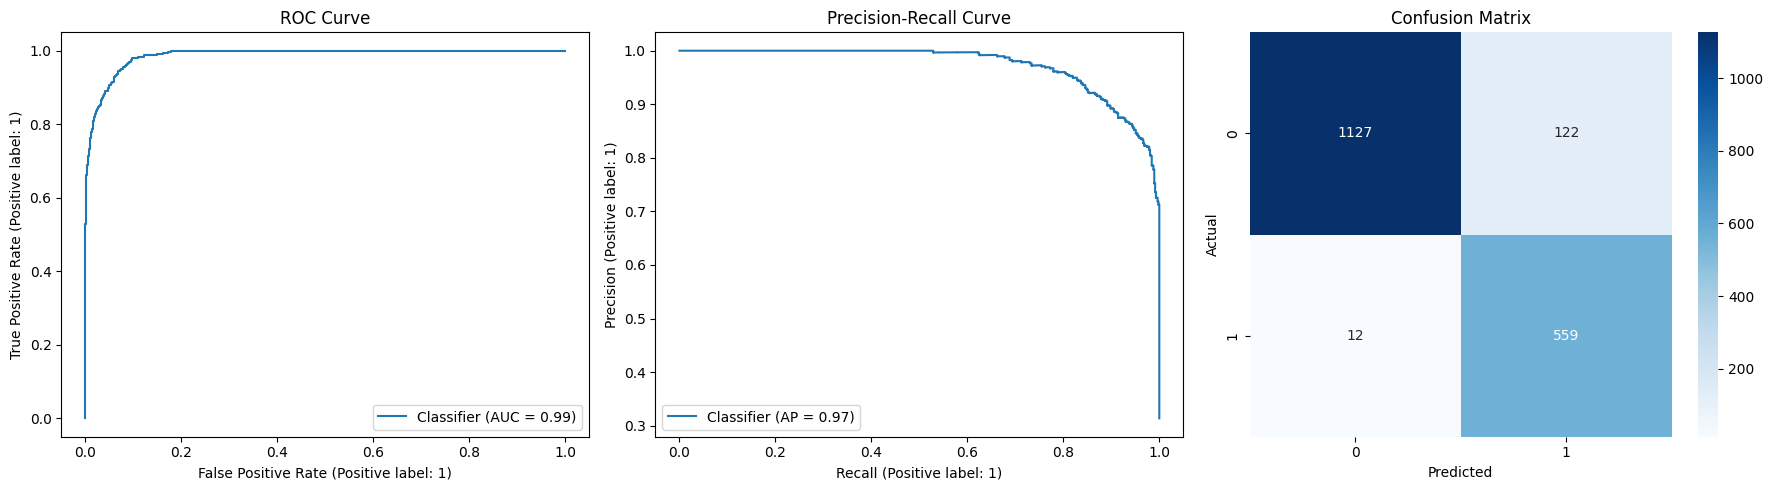

<ipython-input-5-07528328a46b>:88: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[features] = data[features].fillna(method='ffill').fillna(0)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.7057 - loss: 0.5781 - precision: 0.3862 - recall: 0.5232 - val_accuracy: 0.7878 - val_loss: 0.4418 - val_precision: 1.0000 - val_recall: 0.0064 - learning_rate: 0.0010
Epoch 2/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8392 - loss: 0.3153 - precision: 0.6577 - recall: 0.5554 - val_accuracy: 0.7885 - val_loss: 0.3864 - val_precision: 1.0000 - val_recall: 0.0096 - learning_rate: 0.0010
Epoch 3/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8702 - loss: 0.2716 - precision: 0.7253 - recall: 0.6025 - val_accuracy: 0.8180 - val_loss: 0.3162 - val_precision: 0.9600 - val_recall: 0.1543 - learning_rate: 0.0010
Epoch 4/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8840 - loss: 0.2480 - precision: 0.7380 - recall: 0.6817 - val_accuracy: 0.8427 - val_loss: 0.2953 - val_precision: 0.9457 - val_recall: 0.2797 - learning_rate: 0.0010
Epoch 5/50
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8968 - loss: 0

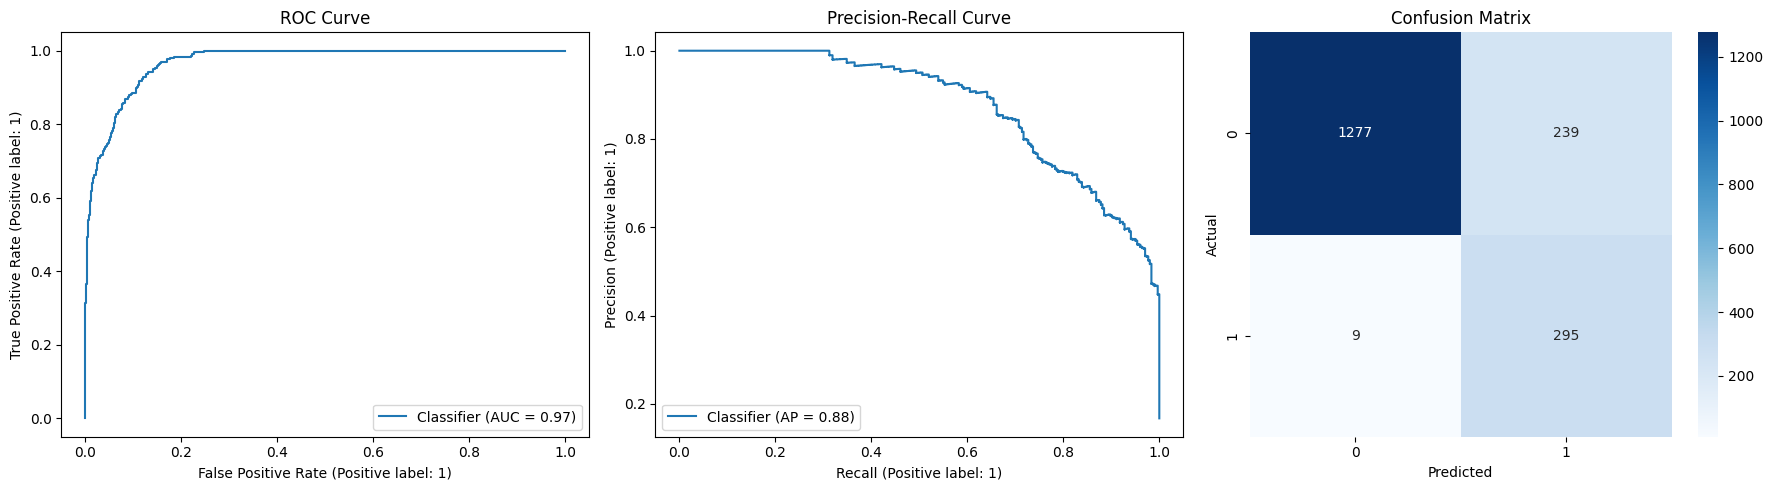

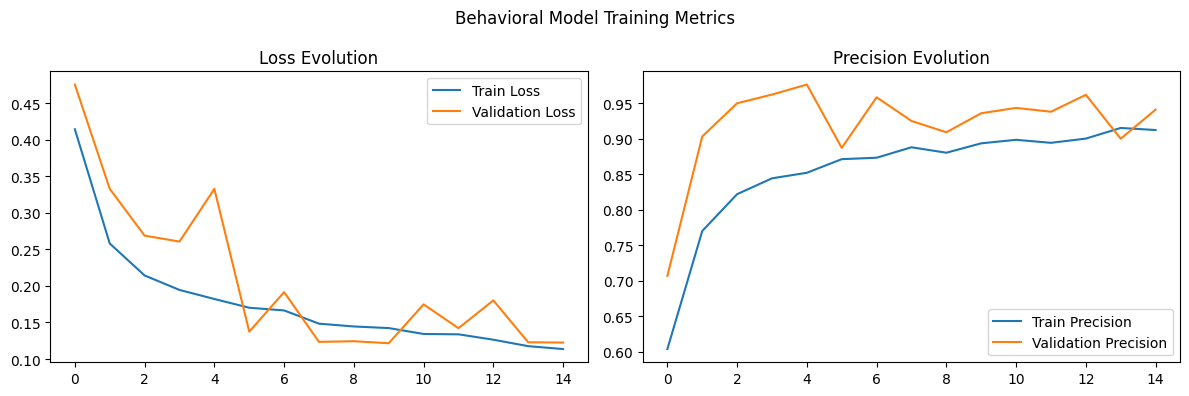

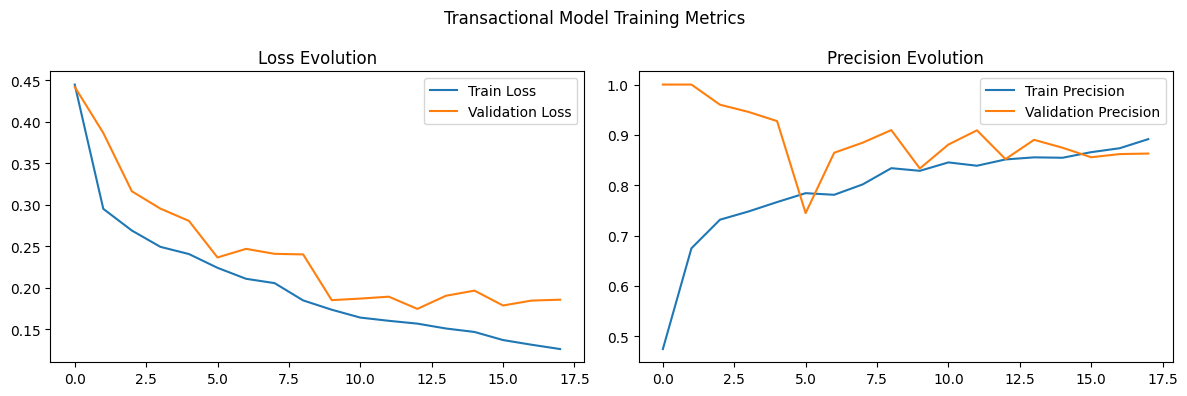

['lstm_scalers.pkl']

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (classification_report, roc_auc_score, 
                             precision_recall_curve, auc, confusion_matrix,
                             PrecisionRecallDisplay, RocCurveDisplay)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Dense, Dropout, Bidirectional,
                                   BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau,
                                      ModelCheckpoint)
import joblib
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class AnomalyDetector:
    def __init__(self, sequence_length=10, test_size=0.2, random_state=42):
        self.sequence_length = sequence_length
        self.test_size = test_size
        self.random_state = random_state
        self.scalers = {}
        self.models = {}
        self.thresholds = {}

    def _create_sequences(self, data, features, target):
        """Create time-series sequences with sliding window"""
        sequences = []
        targets = []
        users = data['UserID'].unique()
        
        for user in users:
            user_data = data[data['UserID'] == user].sort_values('TimeOfTransaction')
            if len(user_data) < self.sequence_length:
                logging.warning(f"User {user} has insufficient data ({len(user_data)} records)")
                continue
                
            values = user_data[features].values
            labels = user_data[target].values
            
            for i in range(len(values) - self.sequence_length + 1):
                sequences.append(values[i:i+self.sequence_length])
                targets.append(labels[i+self.sequence_length-1])
                
        return np.array(sequences), np.array(targets)

    def _build_model(self, input_shape):
        """Construct bidirectional LSTM model with attention"""
        model = Sequential([
            Bidirectional(LSTM(128, return_sequences=True,
                             kernel_initializer='he_normal'), 
                        input_shape=input_shape),
            Dropout(0.3),
            BatchNormalization(),
            Bidirectional(LSTM(64, return_sequences=False)),
            Dropout(0.2),
            BatchNormalization(),
            Dense(32, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
        model.compile(optimizer=optimizer,
                    loss='binary_crossentropy',
                    metrics=['accuracy', 
                           tf.keras.metrics.Precision(name='precision'),
                           tf.keras.metrics.Recall(name='recall')])
        return model

    def preprocess_data(self, data, feature_type):
        """Preprocess data with time-aware validation split"""
        if feature_type == 'behavioral':
            features = behavioral_features
            target = 'behav_AnomalyFlag'
        elif feature_type == 'transactional':
            features = transactional_features
            target = 'tran_AnomalyFlag'
        else:
            raise ValueError("Invalid feature type. Use 'behavioral' or 'transactional'")

        # Handle missing values
        data[features] = data[features].fillna(method='ffill').fillna(0)
        
        # Create sequences
        X, y = self._create_sequences(data, features, target)
        
        # Time-aware train-test split
        split_idx = int(len(X) * (1 - self.test_size))
        X_train, X_test = X[:split_idx], X[split_idx:]
        y_train, y_test = y[:split_idx], y[split_idx:]
        
        # Scale features
        self.scalers[feature_type] = MinMaxScaler()
        X_train = self.scalers[feature_type].fit_transform(
            X_train.reshape(-1, len(features))).reshape(X_train.shape)
        X_test = self.scalers[feature_type].transform(
            X_test.reshape(-1, len(features))).reshape(X_test.shape)
            
        return X_train, X_test, y_train, y_test

    def train_model(self, X_train, y_train, feature_type):
        """Train model with early stopping and checkpointing"""
        callbacks = [
            EarlyStopping(patience=5, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=3),
            ModelCheckpoint(f'best_{feature_type}_model.keras', save_best_only=True)
        ]
        
        model = self._build_model(X_train.shape[1:])
        history = model.fit(
            X_train, y_train,
            epochs=50,
            batch_size=64,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
        
        self.models[feature_type] = model
        return history

    def evaluate_model(self, X_test, y_test, feature_type):
        """Comprehensive model evaluation"""
        model = self.models[feature_type]
        y_pred = model.predict(X_test).flatten()
        
        # Dynamic threshold selection using Youden's J statistic
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        self.thresholds[feature_type] = optimal_threshold
        
        y_pred_bin = (y_pred >= optimal_threshold).astype(int)
        
        # Generate reports
        print(f"\n{'='*40}\n{feature_type.capitalize()} Model Evaluation\n{'='*40}")
        print(classification_report(y_test, y_pred_bin))
        print(f"AUC-ROC: {roc_auc_score(y_test, y_pred):.4f}")
        print(f"Optimal Threshold: {optimal_threshold:.4f}")
        
        # Calculate PR AUC
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        pr_auc = auc(recall, precision)
        print(f"PR AUC: {pr_auc:.4f}")
        
        # Plot metrics
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        
        # ROC Curve
        RocCurveDisplay.from_predictions(y_test, y_pred, ax=ax[0])
        ax[0].set_title('ROC Curve')
        
        # Precision-Recall Curve
        PrecisionRecallDisplay.from_predictions(y_test, y_pred, ax=ax[1])
        ax[1].set_title('Precision-Recall Curve')
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_bin)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[2])
        ax[2].set_title('Confusion Matrix')
        ax[2].set_xlabel('Predicted')
        ax[2].set_ylabel('Actual')
        
        plt.tight_layout()
        plt.show()
        
        return y_pred, optimal_threshold

    def detect_anomalies(self, new_data, feature_type):
        """Detect anomalies in new data"""
        if feature_type not in self.models:
            raise ValueError("Model not trained for this feature type")
            
        features = behavioral_features if feature_type == 'behavioral' else transactional_features
        sequences, _ = self._create_sequences(new_data, features, '')
        
        if len(sequences) == 0:
            return np.array([])
            
        # Scale and predict
        scaled_sequences = self.scalers[feature_type].transform(
            sequences.reshape(-1, len(features))).reshape(sequences.shape)
        predictions = self.models[feature_type].predict(scaled_sequences).flatten()
        anomalies = predictions >= self.thresholds[feature_type]
        
        return anomalies

# Main execution flow
if __name__ == "__main__":
    # Load and prepare data
    data['TimeOfTransaction'] = pd.to_datetime(data['TimeOfTransaction'])
    
    # Initialize detector
    detector = AnomalyDetector(sequence_length=10, test_size=0.2)
    
    # Process and train behavioral model
    X_train_behav, X_test_behav, y_train_behav, y_test_behav = detector.preprocess_data(
        data, 'behavioral')
    behav_history = detector.train_model(X_train_behav, y_train_behav, 'behavioral')
    behav_pred, behav_threshold = detector.evaluate_model(
        X_test_behav, y_test_behav, 'behavioral')
    
    # Process and train transactional model
    X_train_tran, X_test_tran, y_train_tran, y_test_tran = detector.preprocess_data(
        data, 'transactional')
    tran_history = detector.train_model(X_train_tran, y_train_tran, 'transactional')
    tran_pred, tran_threshold = detector.evaluate_model(
        X_test_tran, y_test_tran, 'transactional')
    
    # Save models and scalers
    joblib.dump(detector.scalers, 'anomaly_scalers.pkl')
    detector.models['behavioral'].save('behavioral_model.h5')
    detector.models['transactional'].save('transactional_model.h5')
    
    # Plot training history
    def plot_history(history, title):
        fig, ax = plt.subplots(1, 2, figsize=(12, 4))
        ax[0].plot(history.history['loss'], label='Train Loss')
        ax[0].plot(history.history['val_loss'], label='Validation Loss')
        ax[0].set_title('Loss Evolution')
        ax[0].legend()
        
        ax[1].plot(history.history['precision'], label='Train Precision')
        ax[1].plot(history.history['val_precision'], label='Validation Precision')
        ax[1].set_title('Precision Evolution')
        ax[1].legend()
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
    
    plot_history(behav_history, 'Behavioral Model Training Metrics')
    plot_history(tran_history, 'Transactional Model Training Metrics')


# Save LSTM models with custom metrics
from tensorflow.keras import metrics

# Add custom objects for metrics
custom_objects = {
    'precision': metrics.Precision(name='precision'),
    'recall': metrics.Recall(name='recall')
}

detector.models['behavioral'].save('lstm_behavioral_model.h5', save_format='h5')
detector.models['transactional'].save('lstm_transactional_model.h5', save_format='h5')

# Save scalers with joblib
joblib.dump(detector.scalers, 'lstm_scalers.pkl')

### LightGBM/XGBoost

[LightGBM] [Info] Number of positive: 3531, number of negative: 4469
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.441375 -> initscore=-0.235584
[LightGBM] [Info] Start training from score -0.235584
LightGBM Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      1117
         1.0       0.94      0.98      0.96       883

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000

LightGBM Accuracy: 0.967
LightGBM AUC-ROC: 0.9959404285260937


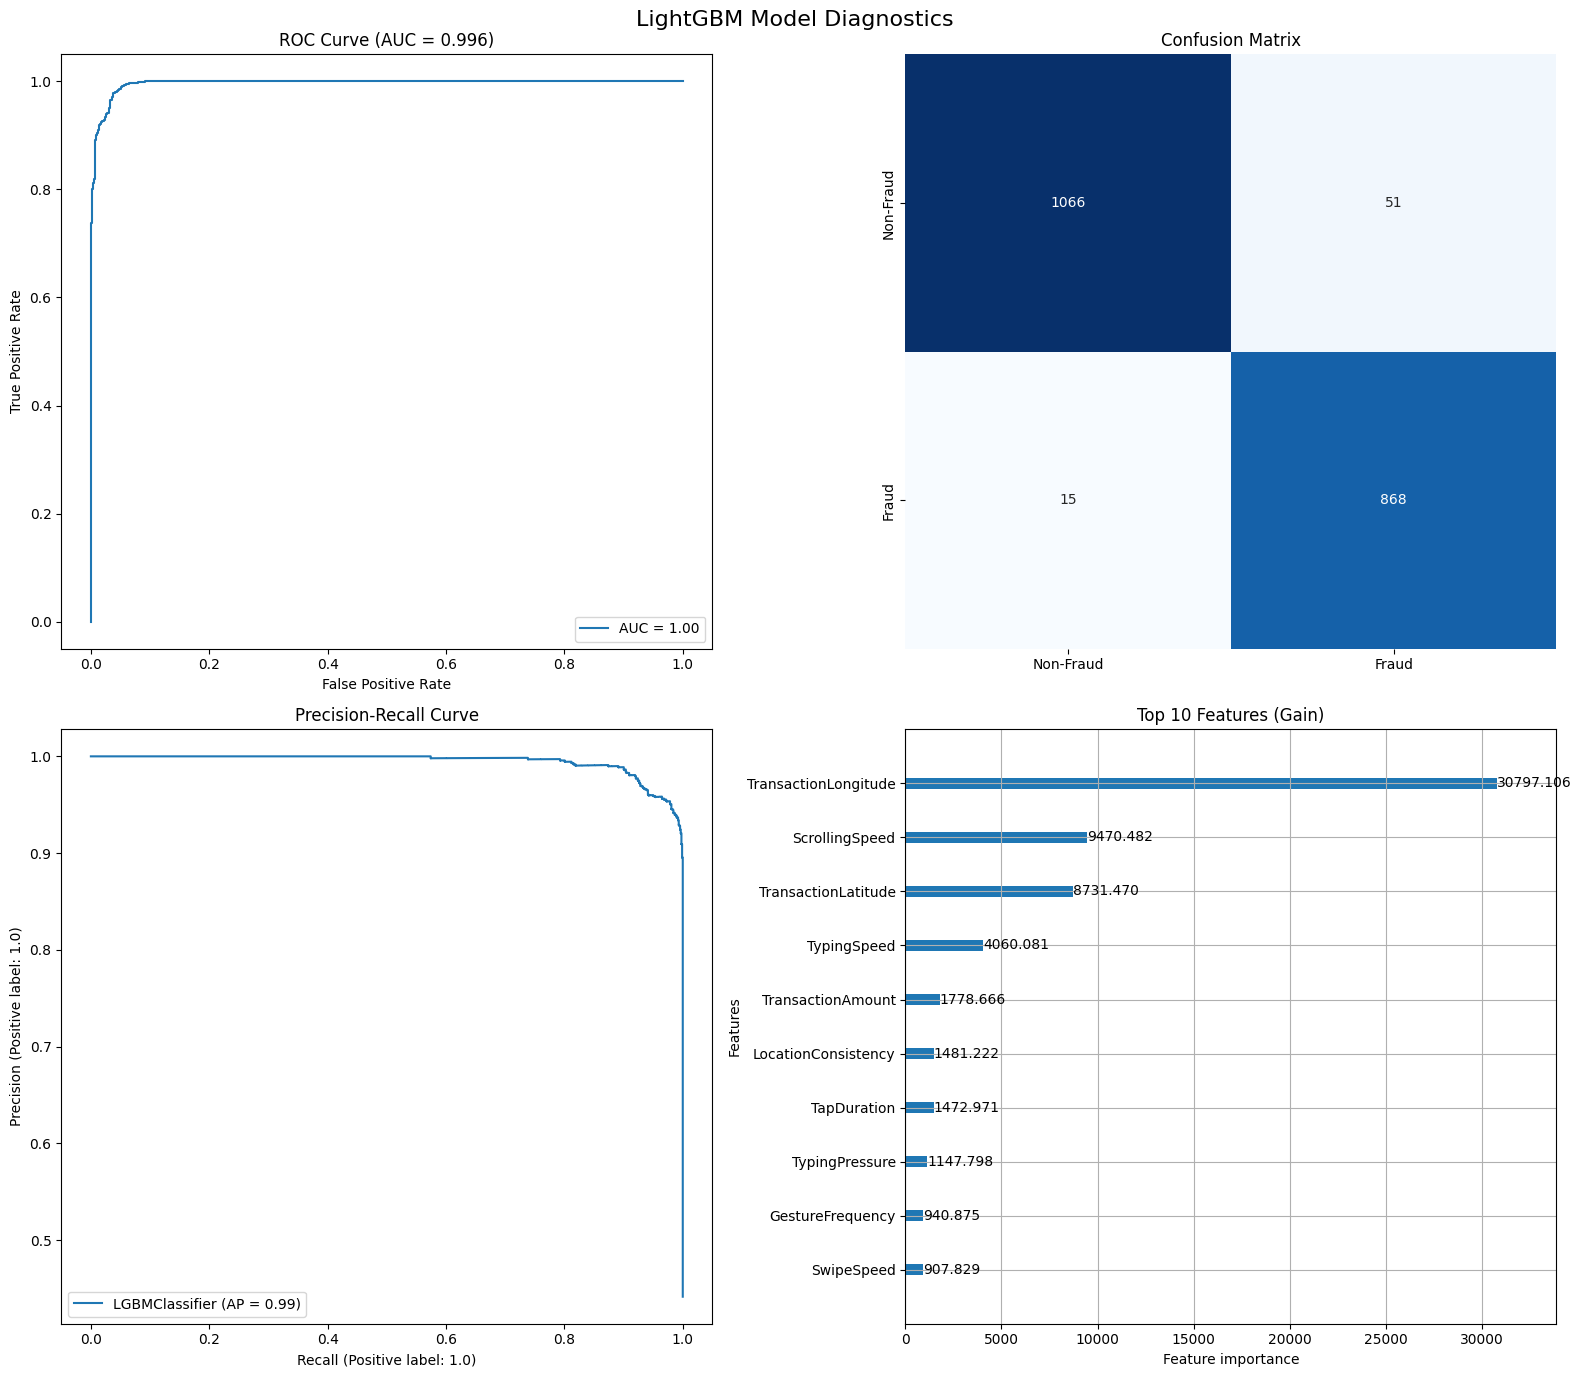


XGBoost Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97      1117
         1.0       0.94      0.98      0.96       883

    accuracy                           0.96      2000
   macro avg       0.96      0.97      0.96      2000
weighted avg       0.97      0.96      0.96      2000

XGBoost Accuracy: 0.964
XGBoost AUC-ROC: 0.9956109178545104


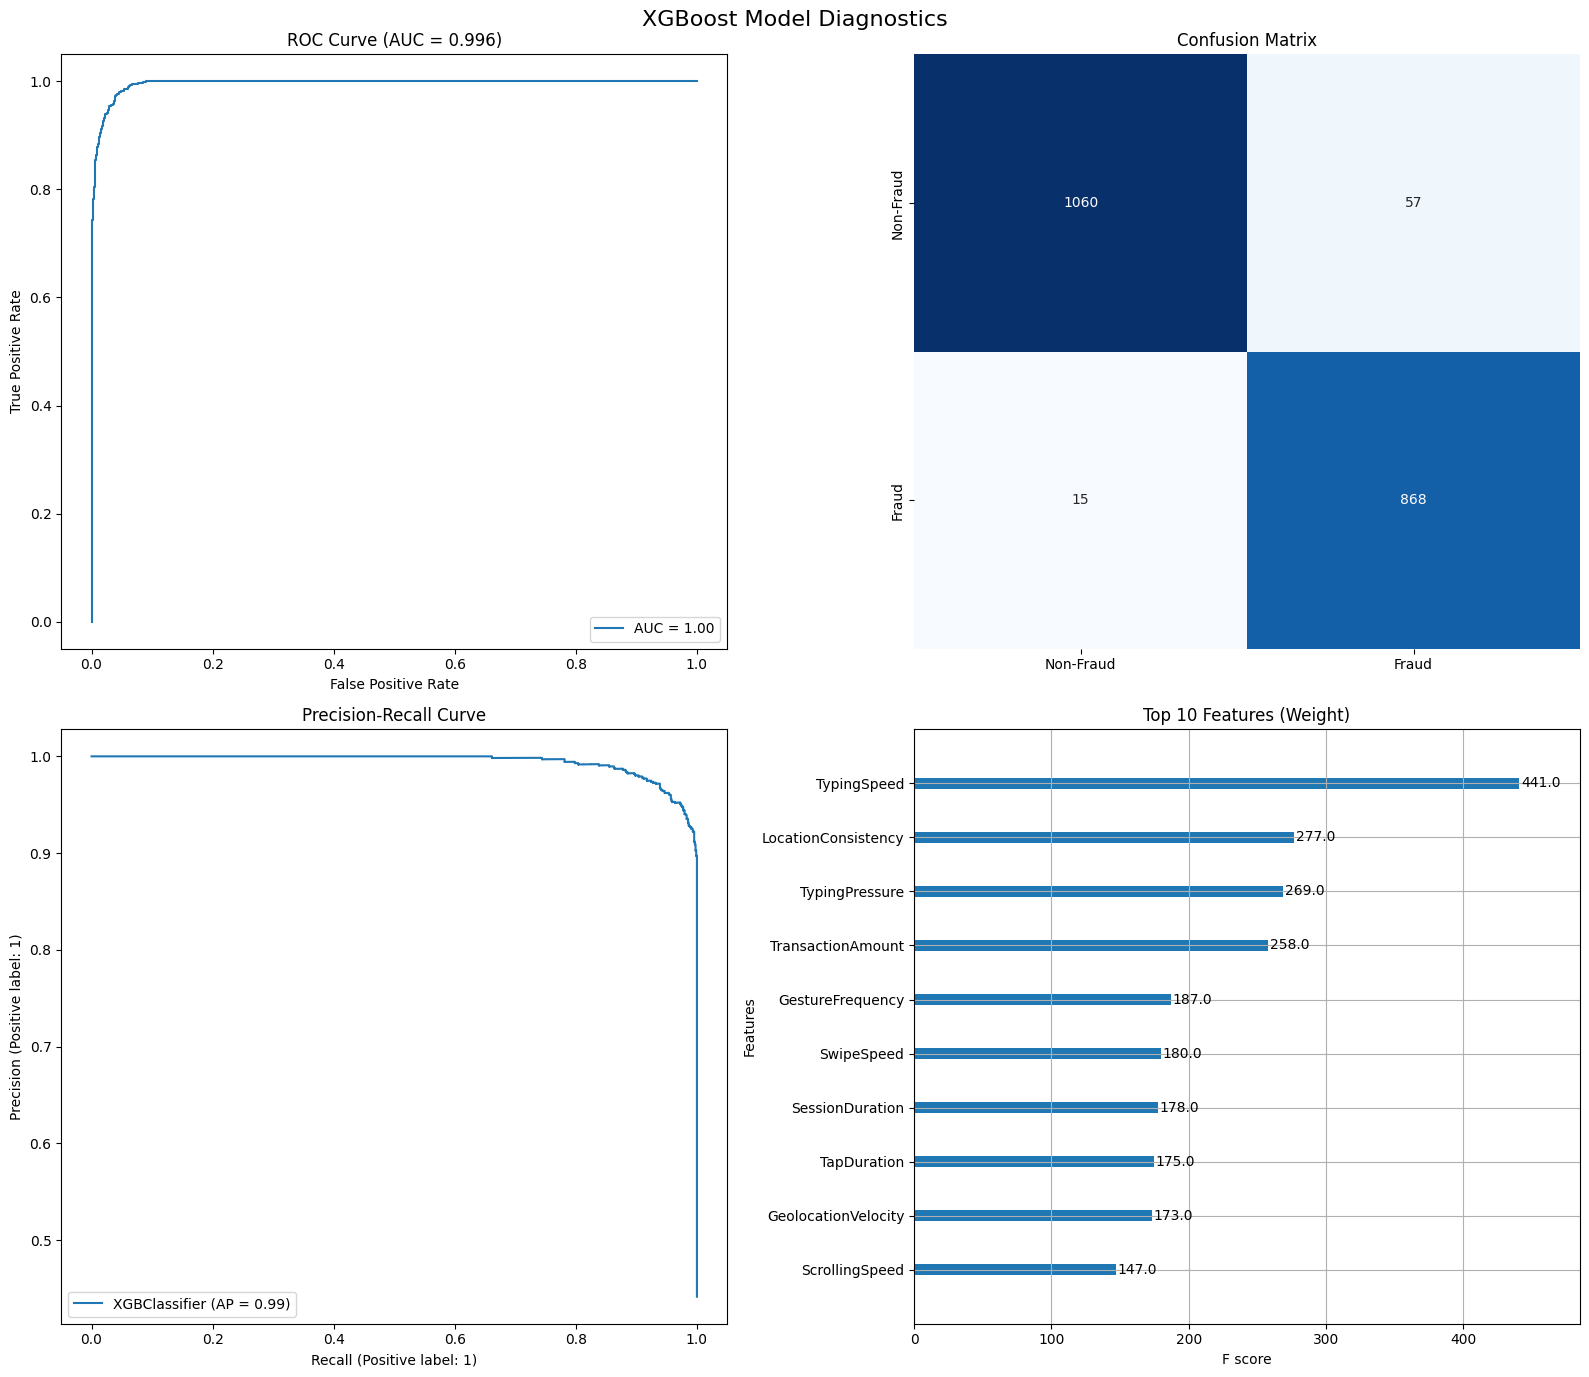

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define features and target
features = [
    'TypingSpeed', 'TypingPressure', 'SwipeSpeed', 'TapDuration', 'ScrollingSpeed',
    'SessionDuration', 'SwipeDirection', 'TouchHeatmap', 'GestureFrequency', 'NavigationFlow',
    'TransactionAmount', 'TransactionType', 'TransactionMethod', 'TransactionLatitude', 'TransactionLongitude',
    'SuccessFailureStatus', 'AuthenticationAttempts', 'MFATrigger', 'HolidayIndicator', 'EventBasedIndicator', 'TimeConsistency',
    'TransactionFrequency', 'LocationConsistency', 'GeolocationVelocity'
]
target = 'IsFraud'

# Aggregate user-based features (e.g., mean/median transaction amounts per session)
data['MeanTransactionAmount'] = data.groupby('UserID')['TransactionAmount'].transform('mean')
data['MedianTransactionAmount'] = data.groupby('UserID')['TransactionAmount'].transform('median')
features.extend(['MeanTransactionAmount', 'MedianTransactionAmount'])

# Split the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train LightGBM model
fraud_ratio = len(data[data['IsFraud'] == 0]) / len(data[data['IsFraud'] == 1])
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, scale_pos_weight=fraud_ratio, random_state=42)
lgb_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100, 
    learning_rate=0.1, 
    scale_pos_weight=fraud_ratio, 
    eval_metric='logloss', 
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Evaluate LightGBM
lgb_predictions = lgb_model.predict(X_test)
print("LightGBM Classification Report:")
print(classification_report(y_test, lgb_predictions))
print("LightGBM Accuracy:", accuracy_score(y_test, lgb_predictions))
print("LightGBM AUC-ROC:", roc_auc_score(y_test, lgb_model.predict_proba(X_test)[:, 1]))

# === After evaluating LightGBM ===
# Generate plots for LightGBM
fig_lgb, axes_lgb = plt.subplots(2, 2, figsize=(16, 14))
((ax1, ax2), (ax3, ax4)) = axes_lgb
fig_lgb.suptitle('LightGBM Model Diagnostics', fontsize=16)

# 1. ROC Curve
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, lgb_model.predict_proba(X_test)[:, 1])
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)
RocCurveDisplay(fpr=fpr_lgb, tpr=tpr_lgb, roc_auc=roc_auc_lgb).plot(ax=ax1)
ax1.set_title(f'ROC Curve (AUC = {roc_auc_lgb:.3f})')

# 2. Confusion Matrix
cm_lgb = confusion_matrix(y_test, lgb_predictions)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Non-Fraud', 'Fraud'], 
           yticklabels=['Non-Fraud', 'Fraud'], ax=ax2)
ax2.set_title('Confusion Matrix')

# 3. Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(lgb_model, X_test, y_test, ax=ax3)
ax3.set_title('Precision-Recall Curve')

# 4. Feature Importance
lgb.plot_importance(lgb_model, ax=ax4, importance_type='gain', max_num_features=10)
ax4.set_title('Top 10 Features (Gain)')

plt.tight_layout()
plt.show()

# Evaluate XGBoost
xgb_predictions = xgb_model.predict(X_test)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost AUC-ROC:", roc_auc_score(y_test, xgb_model.predict_proba(X_test)[:, 1]))

# === After evaluating XGBoost ===
# Generate plots for XGBoost
fig_xgb, axes_xgb = plt.subplots(2, 2, figsize=(16, 14))
((ax1, ax2), (ax3, ax4)) = axes_xgb
fig_xgb.suptitle('XGBoost Model Diagnostics', fontsize=16)

# 1. ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
RocCurveDisplay(fpr=fpr_xgb, tpr=tpr_xgb, roc_auc=roc_auc_xgb).plot(ax=ax1)
ax1.set_title(f'ROC Curve (AUC = {roc_auc_xgb:.3f})')

# 2. Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_predictions)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
           xticklabels=['Non-Fraud', 'Fraud'], 
           yticklabels=['Non-Fraud', 'Fraud'], ax=ax2)
ax2.set_title('Confusion Matrix')

# 3. Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(xgb_model, X_test, y_test, ax=ax3)
ax3.set_title('Precision-Recall Curve')

# 4. Feature Importance
xgb.plot_importance(xgb_model, ax=ax4, importance_type='weight', max_num_features=10)
ax4.set_title('Top 10 Features (Weight)')

plt.tight_layout()
plt.show()

# Save the models
lgb_model.booster_.save_model('lightgbm_fraud_model.txt')
xgb_model.save_model('xgboost_fraud_model.json')


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[LightGBM] [Info] Number of positive: 3557, number of negative: 4443
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3404
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Info] Number of positive: 2846, number of negative: 3554
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3404
[LightGBM] [Info] Number of data poi

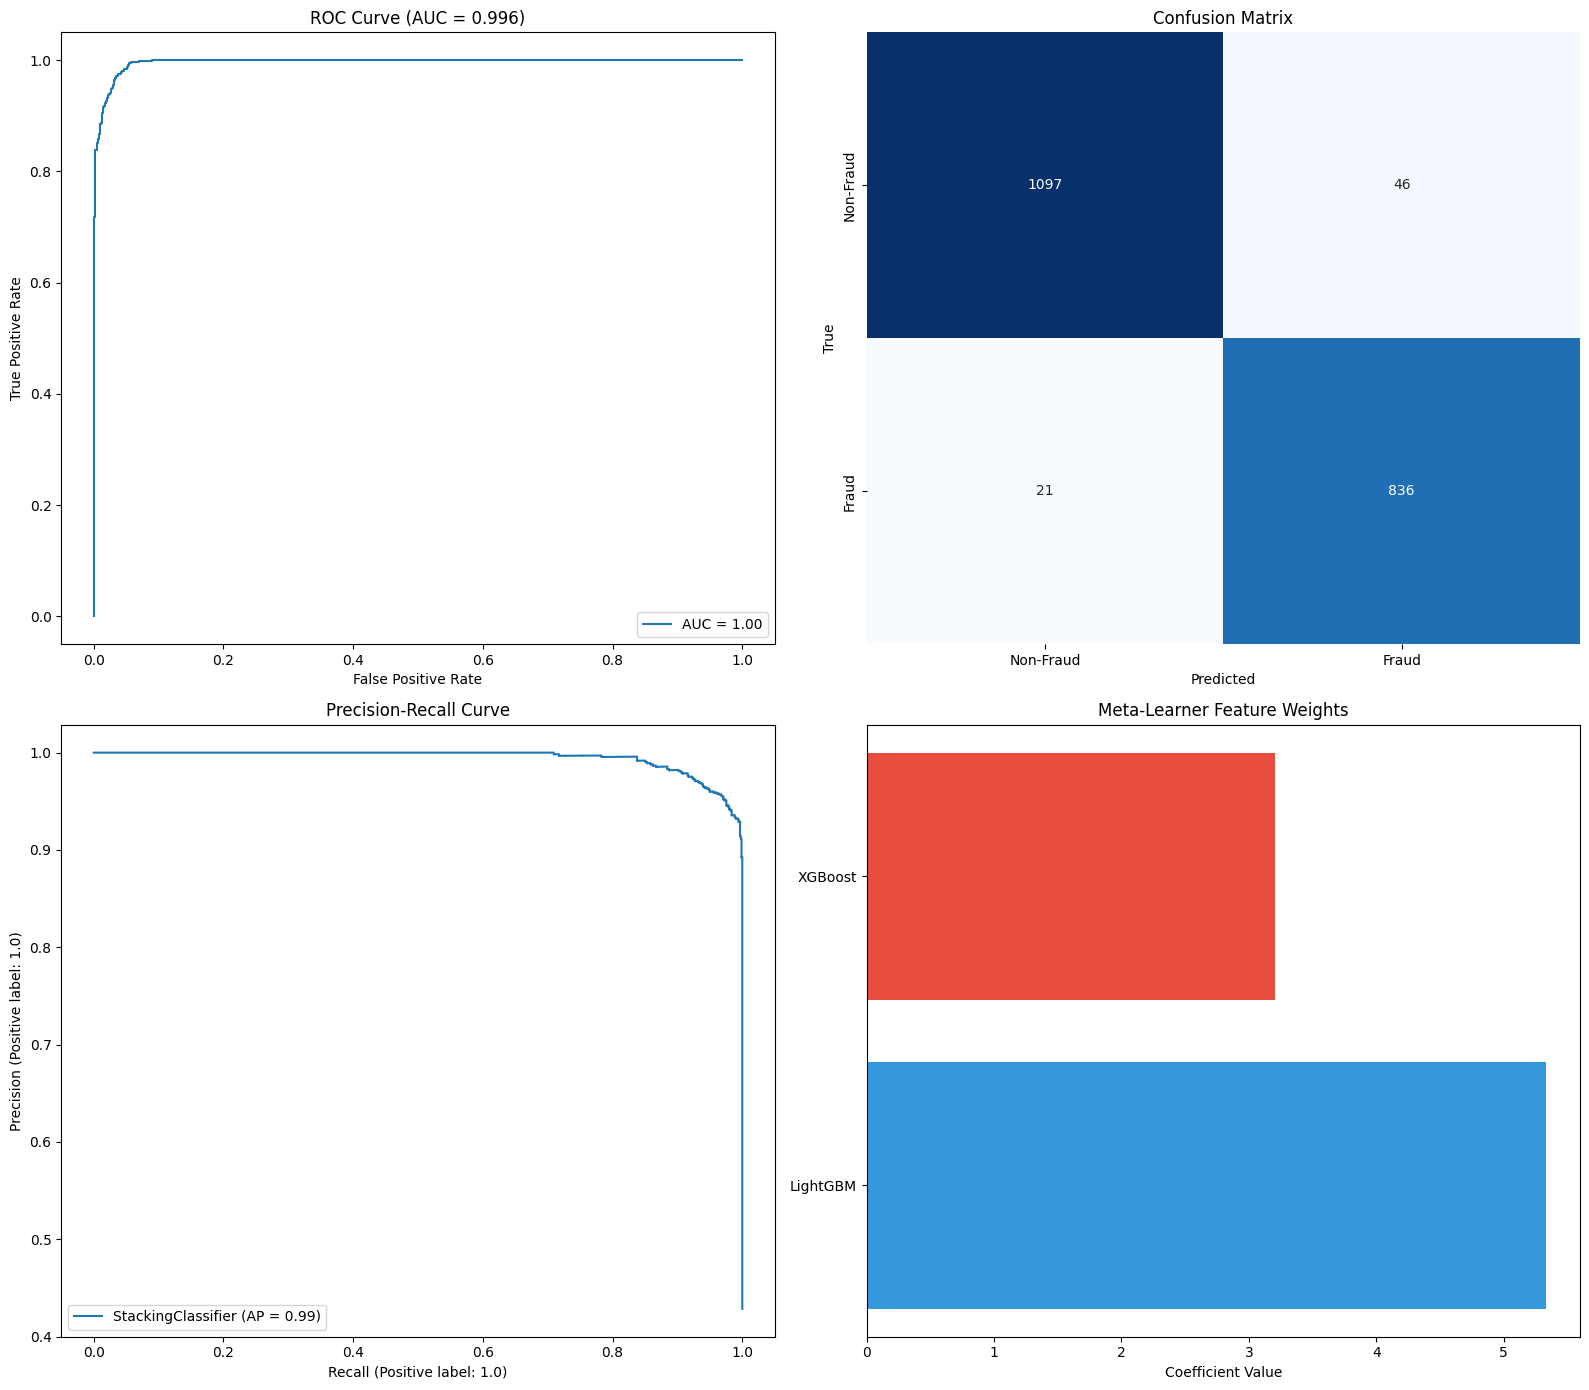

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from joblib import dump
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from tensorflow.keras.models import load_model

# Simplified feature engineering
def create_enhanced_features(data, ae_model_behav, ae_model_tran, behav_scaler, tran_scaler):
    """Simplified feature engineering without LSTM components"""
    # Autoencoder Features
    behav_features = behav_scaler.transform(data[behavioral_features])
    data['ae_behav_error'] = np.mean(np.square(ae_model_behav.predict(behav_features) - behav_features), axis=1)
    
    tran_features = tran_scaler.transform(data[transactional_features])
    data['ae_tran_error'] = np.mean(np.square(ae_model_tran.predict(tran_features) - tran_features), axis=1)

    # Temporal Features
    data['transaction_hour'] = pd.to_datetime(data['TimeOfTransaction']).dt.hour
    data['dow'] = pd.to_datetime(data['TimeOfTransaction']).dt.dayofweek
    
    # User Behavior Features
    data['time_since_last'] = data.groupby('UserID')['TimeOfTransaction'].diff().dt.total_seconds().fillna(0)
    
    return data

# Simplified ensemble model
class FraudDetectionEnsemble:
    def __init__(self):
        self.base_models = [
            ('lgbm', lgb.LGBMClassifier(class_weight='balanced')),
            ('xgb', xgb.XGBClassifier(scale_pos_weight=1.25))
        ]
        self.ensemble = StackingClassifier(
            estimators=self.base_models,
            final_estimator=LogisticRegression(
                max_iter=2000,  # Increased iterations
                class_weight='balanced',
                solver='saga',  # Better for unscaled data
                penalty='l1',   # Helps with feature selection
                C=0.5          # Regularization strength
            ),
        passthrough=False  # Reduces dimensionality
        )

    def train(self, X, y):
        # Directly fit the stacking ensemble (will auto-fit base models)
        self.ensemble.fit(X, y)  # Changed from separate model fitting
        
    def predict(self, X):
        return self.ensemble.predict(X)
    
    def evaluate(self, X, y):
            y_pred = self.predict(X)
            y_proba = self.ensemble.predict_proba(X)[:, 1]
    
            # Create a 2x2 grid for plots
            fig, axes = plt.subplots(2, 2, figsize=(16, 14))
            ((ax1, ax2), (ax3, ax4)) = axes
            
            # Classification Report
            print(classification_report(y, y_pred))
    
            # --- Plot 1: ROC Curve ---
            fpr, tpr, _ = roc_curve(y, y_proba)
            roc_auc = auc(fpr, tpr)
            RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot(ax=ax1)
            ax1.set_title(f'ROC Curve (AUC = {roc_auc:.3f})', fontsize=12)
    
            # --- Plot 2: Confusion Matrix ---
            cm = confusion_matrix(y, y_pred)
            sns.heatmap(
                cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Fraud', 'Fraud'], 
                yticklabels=['Non-Fraud', 'Fraud'], 
                ax=ax2
            )
            ax2.set_xlabel('Predicted', fontsize=10)
            ax2.set_ylabel('True', fontsize=10)
            ax2.set_title('Confusion Matrix', fontsize=12)
    
            # --- Plot 3: Precision-Recall Curve ---
            PrecisionRecallDisplay.from_estimator(self.ensemble, X, y, ax=ax3)
            ax3.set_title('Precision-Recall Curve', fontsize=12)
    
            # --- Plot 4: Meta-Learner Weights ---
            lr_model = self.ensemble.final_estimator_
            feature_names = ['LightGBM', 'XGBoost']
            ax4.barh(feature_names, lr_model.coef_[0], color=['#3498db', '#e74c3c'])
            ax4.set_title('Meta-Learner Feature Weights', fontsize=12)
            ax4.set_xlabel('Coefficient Value', fontsize=10)
    
            plt.tight_layout()
            plt.show()

# Main execution flow
if __name__ == "__main__":
    # Load models and scalers
    behav_ae = load_model('behavioral_autoencoder.keras')
    tran_ae = load_model('transactional_autoencoder.keras')
    behav_scaler = joblib.load('behav_scaler.joblib')
    tran_scaler = joblib.load('tran_scaler.joblib')
    
    # Create enhanced features
    enhanced_data = create_enhanced_features(data, behav_ae, tran_ae, behav_scaler, tran_scaler)
    
    # Select final features
    final_features = [
        'ae_behav_error', 'ae_tran_error',
        'transaction_hour', 'dow', 'time_since_last'
    ] + behavioral_features + transactional_features
    
    X = enhanced_data[final_features]
    y = data['IsFraud']
    
    # Time-based split
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    # Train and evaluate
    ensemble = FraudDetectionEnsemble()
    ensemble.train(X_train, y_train)
    
    print("Test Evaluation:")
    ensemble.evaluate(X_test, y_test)

    # Save model
    dump(ensemble, 'fraud_ensemble.joblib')

In [8]:
X_test.head(5)

,ae_behav_error,ae_tran_error,transaction_hour,dow,time_since_last,TypingSpeed,TypingPressure,SwipeSpeed,TapDuration,ScrollingSpeed,...,TransactionLongitude,SuccessFailureStatus,AuthenticationAttempts,MFATrigger,HolidayIndicator,EventBasedIndicator,TimeConsistency,TransactionFrequency,LocationConsistency,GeolocationVelocity
8000,0.476693,1.183148,12,1,0.0,243.453684,0.771613,760.610994,158.001258,603.435294,...,-121.815354,0,1,1.0,0.0,0,1.0,5,0.004610,0.000000
8001,0.198456,2.008936,12,1,60.0,180.966235,0.490504,562.882771,105.103620,289.830191,...,-122.492446,1,0,0.0,0.0,0,1.0,5,0.173275,0.171206
8002,0.395838,1.038492,12,1,60.0,250.338927,0.816292,810.838069,141.291019,525.320527,...,-121.961113,0,3,1.0,0.0,0,1.0,1,0.085234,0.131215
8003,0.334037,0.836819,12,1,60.0,185.973378,0.451543,604.062186,102.434831,298.492526,...,-122.367992,1,1,1.0,0.0,0,1.0,2,0.090637,0.141121
8004,0.186906,0.850591,12,1,60.0,242.596600,0.691854,721.004786,150.078934,532.826997,...,-122.044409,0,1,1.0,0.0,0,1.0,4,0.055433,0.145750


In [9]:
y_test.head(5)

8000    1.0
8001    0.0
8002    1.0
8003    0.0
8004    1.0
Name: IsFraud, dtype: float64